# Lecture 2.1: The Ishigami Function

The Ishigami (Ishigami-Homma) function is a mathematical function that has been widely used to test the performance of sensitivity analysis methods. 

It takes the following form:

$$f(x_1,x_2,x_3)=\sin(x_1)+A\sin^2(x_2)+B{x_3}^4\sin(x_1)$$

where $x_1$, $x_2$, and $x_3$ are input variables, and $A$ and $B$ are parameters that control the degree of nonlinearity and interaction between the variables.

The Ishigami function is particularly interesting because it exhibits nonlinearity and strong dependence on the input variables. As such, it provides a challenging test case for sensitivity analysis methods.

To run the analysis, we will use the Python package `SALib` (Sensitivity Analysis Library) [1,2]. `SALib` is an open-source Python library for performing sensitivity analysis.

### Importing the required libraries

In `SALib`, the modules `sample` and `analyze` store respectively the functions for generating the samples and for analyzing the results. Here, we use the `sample.sobol` function to generate the samples using the Saltelli sampling scheme (`saltelli` function is actually deprecated). And the `analyze.sobol` function to analyze the results using the Sobol sensitivity indices.

We also import `numpy`, as it is used by SALib to store the model inputs and outputs in a matrix. And `matplotlib` and `plotly` for plotting the results and analysis.

In [2]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# set font as Stix 
plt.rcParams["mathtext.fontset"] = "stix"

### Defining the Ishigami function

To run our first example on Sensitivity Analysis, we will define the Ishigami function in Python using only the `numpy` library as it is used by `SALib` to work with the model inputs and outputs.

***Note**: SALib has a builtin Ishigami function, which can be used to test the performance of the sensitivity analysis methods. But for the purpose of this course, we will present the Ishigami function from scratch.*

In [3]:
def ishigami_model(X: np.ndarray, A: float = 7.0, B: float = 0.1) -> np.ndarray:
    r"""
    Parameters
    ----------
    X : np.ndarray
        An `N*D` array holding values for each parameter, where `N` is the
        number of samples and `D` is the number of parameters
        (in this case, three).
        X[:, 0] = x1
        X[:, 1] = x2
        X[:, 2] = x3
    A : float
        Constant `A` parameter
    B : float
        Constant `B` parameter

    Returns
    -------
    Y : np.ndarray
        A length `N` array of model outputs
    """
    Y = np.zeros(X.shape[0])
    Y = (
        np.sin(X[:, 0])
        + A * np.power(np.sin(X[:, 1]), 2)
        + B * np.power(X[:, 2], 4) * np.sin(X[:, 0])
    )

    return Y

### Defining the Analysis Problem

Next, we define the model inputs and run a simple problem.  The Ishigami function has three inputs, $x_1, x_2, x_3$ where $x_i \in [-\pi, \pi]$.

The problem is defined in 4 steps:
1. **Define the model inputs and their respective bounds** to be evaluated in the model. In `SALib`, we define a `dict` storing: the number of inputs; the names of the inputs; and the bounds on each input, as shown below.
2. **Generate the samples** using some sampling scheme. The `SALib.sample` function takes as arguments the number of samples to be generated and the problem definition.
3. **Evaluate the model** at each sample point. The `numpy` structure is employed to iterate over the samples and evaluate the model at each point.
4. **Perform analysis** using some analysis algorithm. The `SALib.analyze` function takes as arguments the problem definition and the model outputs.

In [4]:
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

# Generate samples
param_values = sample(problem, 1024)

# Run model (example)
Y = ishigami_model(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True, conf_level=0.95)

          ST   ST_conf
x1  0.550257  0.091809
x2  0.442096  0.041966
x3  0.235429  0.023375
          S1   S1_conf
x1  0.309883  0.061929
x2  0.442717  0.051779
x3  0.001923  0.052864
                S2   S2_conf
(x1, x2)  0.002593  0.087381
(x1, x3)  0.232295  0.102310
(x2, x3) -0.001215  0.055309


`Si` is a Python `dict` with the keys `"S1"`, `"S2"`, `"ST"`, `"S1_conf"`, `"S2_conf"`, and `"ST_conf"` as can be seen above.

The `_conf` keys store the corresponding confidence intervals, typically with a confidence level of $95%$.
___

### Output Visualization and Analysis

Each dictionary key stores an array of size $n$, where $n$ is the number of input parameters.

Although, the second-order indices, `"S2"` and `"S2_conf"`, are stored in an upper triangular matrix, where position $(i,j)$ corresponds to the interaction between the $i$-th and $j$-th input parameters.

#### Model Output
First, let's plot the output of the model in function of the input parameters $x_1$, $x_2$, and $x_3$. We present a pair plot of the model outputs in function of the input parameters in a reduced space (2D) as it compares the model outputs in function of each pair of input parameters. As the problem has 3 randomized variables we also present an interactive 3D plot using the `plotly` library.

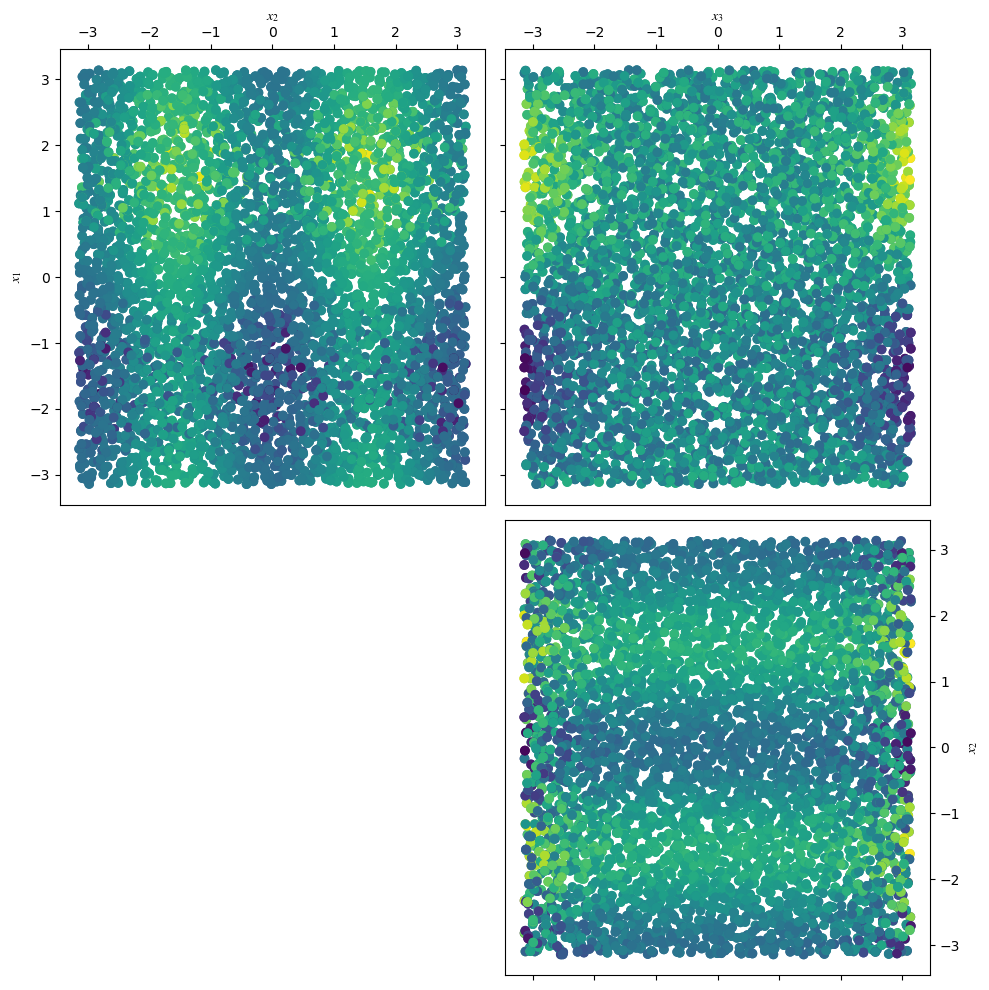

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(param_values[:, 1], param_values[:, 0], c=Y)
ax[0, 0].set_ylabel(r'$x_1$')
ax[0, 0].set_xlabel(r'$x_2$')
ax[0, 0].xaxis.tick_top()
ax[0, 0].xaxis.set_label_position('top')

ax[0, 1].scatter(param_values[:, 2], param_values[:, 0], c=Y)
ax[0, 1].set_xlabel(r'$x_3$')
ax[0, 1].xaxis.tick_top()
ax[0, 1].xaxis.set_label_position('top')
ax[0, 1].set_ylabel('')
ax[0, 1].set_yticklabels([])

ax[1, 1].scatter(param_values[:, 2], param_values[:, 1], c=Y)
ax[1, 1].set_ylabel(r'$x_2$')
ax[1, 1].set_xlabel('')
ax[1, 1].set_xticklabels([])
ax[1, 1].yaxis.set_label_position('right')
ax[1, 1].yaxis.tick_right()

ax[1, 0].axis('off')
plt.tight_layout()
plt.show()

In [6]:
fig = px.scatter_3d(x=param_values[:, 0], y=param_values[:, 1], z=param_values[:, 2], color=Y)
fig.update_layout(scene = dict(
                    xaxis_title=r'$x_1$',
                    yaxis_title=r'$x_2$',
                    zaxis_title=r'$x_3$'))
fig.show()

#### Sensitivity Analysis

Finally we plot the resuls of the sensitivity analysis. We present the first-order and total sensitivity indices in a bar plot. And the second-order indices in a heatmap.

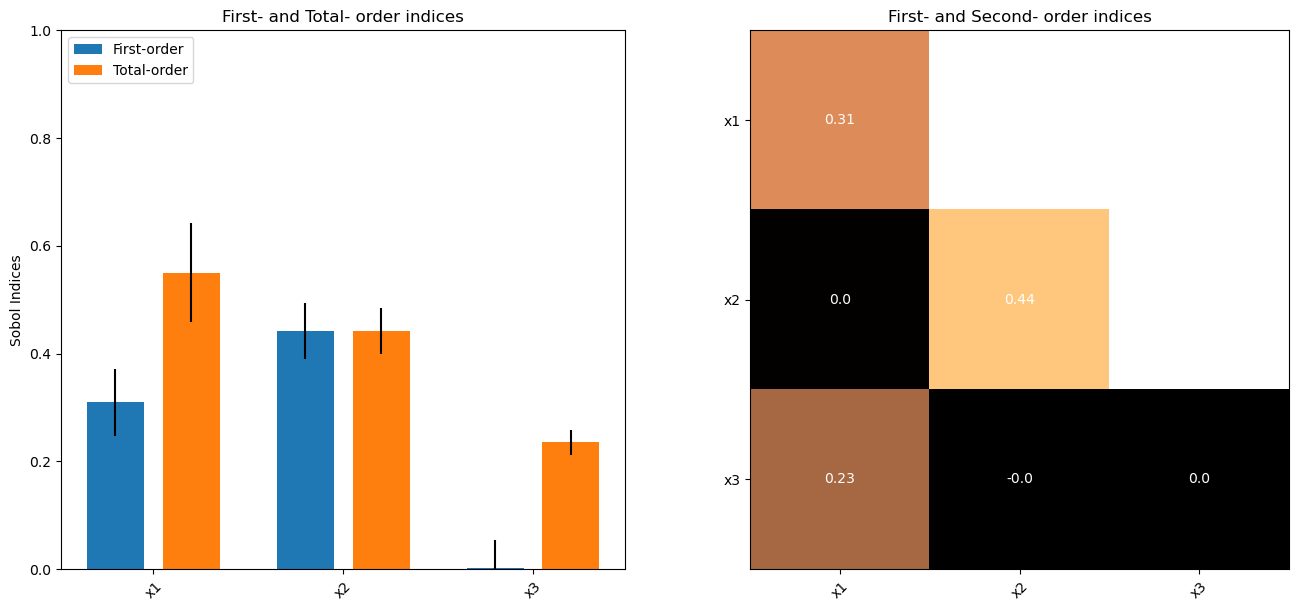

In [7]:
# 3 subplots: 
# 1) bar plot first-order indices, 
# 2) bar plot second-order indices,
# 3) bar plot total-order indices.
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].bar(np.array(range(len(problem['names']))) - 0.2, Si['S1'], yerr=Si['S1_conf'], width=0.3, label='First-order')
axes[0].bar(np.array(range(len(problem['names']))) + 0.2, Si['ST'], yerr=Si['ST_conf'], width=0.3, label='Total-order')

axes[0].set_ylabel('Sobol Indices')
axes[0].set_ylim([0, 1])
axes[0].set_xticks(range(len(problem['names'])))
axes[0].set_xticklabels(problem['names'], rotation=45)
axes[0].legend(loc='upper left')

axes[0].set_title('First- and Total- order indices')

si_matrix = Si['S2'].T
np.fill_diagonal(si_matrix, Si['S1'])

axes[1].imshow(si_matrix, cmap='copper', interpolation='nearest')
for i in range(Si['S2'].shape[0]):
    for j in range(Si['S2'].shape[1]):
        axes[1].text(j, i, round(si_matrix[i, j], 2), ha="center", va="center", color="w")
axes[1].set_xticks(range(len(problem['names'])))
axes[1].set_xticklabels(problem['names'], rotation=45)
axes[1].set_yticks(range(len(problem['names'])))
axes[1].set_yticklabels(problem['names'])

axes[1].set_title('First- and Second- order indices')

plt.show()

Through the sensitivity analysis we can see that $x_2$ has the greatest impact on the model output alone (first-order indices), and present no significant interaction with the other input parameters affecting the model output (differencer between total- and first- order indices).

The total-order indices are substantially larger than the first-order indices for $x_1$ and $x_3$, indicating that the interaction between these input parameters is significant. While $x_3$ present no significant impact on the model output alone.

These results agrees with out intuition as the equation presents a term $B{x_3}^4\sin(x_1)$, which is a function of $x_1$ and $x_3$, but there is no term in the equation that is a function of $x_2$ and another input parameter.

___
### Exercises

1. Change the values of $A$ and $B$ and perform the sensitivity analysis again. What do you observe? Are the results consistent with the changes in the Ishigami function through $A$ and $B$? What about interactions?

2. Change the intervals for the input parameters $x_1$, $x_2$, and $x_3$ and perform the analysis again. What do you observe?

___
### References
[1] Ishigami, T., Homma, T., 1990.
        *An importance quantification technique in uncertainty analysis for computer models.*
        Proceedings. First International Symposium on Uncertainty Modeling
        and Analysis.
        https://doi.org/10.1109/ISUMA.1990.151285

[2] Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J.,
        Gatelli, D., Saisana, M., Tarantola, S., 2008.
        *Global Sensitivity Analysis: The Primer.* Wiley, West Sussex, U.K.
        https://dx.doi.org/10.1002/9780470725184

[3] Homma, T., Saltelli, A. 1996.
        *Importance measures in global sensitivity analysis of nonlinear models.*
        Reliab. Eng. Syst. Saf. 52 (1), 1–17.
        https://doi.org/10.1016/0951-8320(96)00002-6